In [1]:
from IPython.display import display, HTML
image_path = r"brain-tumor-treatment-radiology-web.jpg"

display(HTML(f'<div style="text-align: center;margin-top:20px"><img src="{image_path}" style="max-width: 100%; height: 500px;" /></div>'))


# **Project Overview**

# 🎯 Brain Tumor Segmentation Using U-Net with EfficientNetB0 Encoder  
Brain tumor segmentation is a crucial application of deep learning in medical image analysis. This project implements an optimized U-Net architecture using **EfficientNetB0 as the encoder**, ensuring both accuracy and efficiency in training and inference. The pipeline includes data preprocessing, augmentation, model training, and evaluation using various metrics.

---

## 📊 Project Pipeline

### 1️⃣ Data Collection & Structure  
- **Dataset:** 3064 MRI images and their corresponding masks.  
- **Image Format:** Grayscale (single-channel) images.  
- **Directory Structure:**  
  - `Data/images` → MRI scans.  
  - `Data/masks` → Segmentation masks.  

---

### 2️⃣ Data Preprocessing  
- **Resizing:** All images are resized to **224×224** pixels.  
- **Normalization:** Pixel values are scaled from **0-255 to 0-1**.  
- **Dimension Expansion:** Grayscale images reshaped to **(224, 224, 3)** for EfficientNet compatibility.  

---

### 3️⃣ Data Splitting  
- **Train/Test Split:** **80%** for training, **20%** for testing.  
- **Validation Split:** **10%** of training data separated for validation.  

---

### 4️⃣ Data Augmentation  
Augmentation improves generalization and robustness.  

#### 🔹 Training Data  
- **Horizontal Flip**  
- **Random Rotation (90°)**  
- **Brightness and Contrast Adjustment**  
- **Gamma Correction**  

#### 🔹 Validation & Testing Data  
- **Only Normalization** (no random transformations).  

---

## 🧠 Model Architecture  

### **U-Net with EfficientNetB0 Encoder**  
EfficientNetB0 is used as the feature extractor, leveraging pre-trained weights for efficient learning.  

### **Loss Function & Metric**  
- **Loss Function:** Binary Cross-Entropy + Dice Loss  
- **Evaluation Metric:** Dice Coefficient  

---

## 🎯 Model Training Strategy  

- **Optimizer:** Adam (`lr=1e-4`)  
- **Batch Size:** 32  
- **Early Stopping:** If validation Dice coefficient reaches **0.80**, training stops to prevent overfitting.  
- **Epochs:** Maximum **50** (early stopping applied).  

---

## 📈 Model Evaluation  

After training, the model is evaluated using the **test set**, and results are analyzed using:  

1️⃣ **Classification Report**  
2️⃣ **Confusion Matrix**  
3️⃣ **Dice Coefficient**  

Additionally, the **Dice coefficient** is computed for validation data after training.

---

## 🧪 Testing on Random Image  

To visually assess model performance, a **random test image** is selected, and the predicted mask is compared against the ground truth.  

- **Prediction Process:**  
  - Load and preprocess the test image & mask.  
  - Predict the mask using the trained model.  
  - Convert the predicted mask to binary (threshold = 0.5).  
  - Compute the Dice coefficient.  
  - Display the input image, predicted mask, and original mask side by side.  

---



# **Import Libraries and Define Metrics & Callback**

In [1]:

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Dice coefficient function for segmentation evaluation
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom callback: stops training when validation dice coefficient reaches a threshold (80%)
class DiceEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.8):
        super(DiceEarlyStopping, self).__init__()
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_dice = logs.get('val_dice_coef')
        if val_dice is not None and val_dice >= self.threshold:
            print(f"\nReached {self.threshold*100:.0f}% dice on validation data. Stopping training!")
            self.model.stop_training = True


# **Data Loading, Preprocessing & Displaying Sample Images**

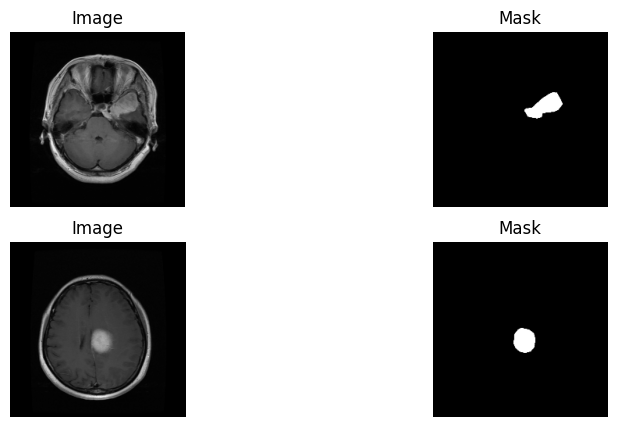

In [2]:
# ====================================================
# Part 2: Data Loading, Preprocessing & Displaying Sample Images
# ====================================================
# Define directories for images and masks
image_dir = "Data/images"
mask_dir = "Data/masks"

# Get sorted lists of image and mask file paths
image_paths = sorted(glob.glob(os.path.join(image_dir, "*")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

# Function to load and preprocess an image (resize and normalize)
def load_image(path, target_size=(224, 224)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # normalize to [0,1]
    return img

# Function to load and preprocess a mask (resize, add channel dimension, and normalize)
def load_mask(path, target_size=(224, 224)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask / 255.0  # normalize to [0,1]
    return mask

# Load images and masks into lists
images = [load_image(p) for p in image_paths]
masks = [load_mask(p) for p in mask_paths]

# Display 2 sample images with their corresponding masks
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 2, i*2+1)
    plt.imshow(images[i])
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(2, 2, i*2+2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis("off")
plt.show()


#  **Data Augmentation** 

In [3]:
# ====================================================
# Part 3: Data Augmentation and Generator
# ====================================================
def random_augment(image, mask):
    """
    Apply random augmentations to the image and mask.
    """
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    # Random vertical flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    # You can add more augmentations here if needed.
    return image, mask

def data_generator(images, masks, batch_size=16, augment=False):
    """
    Generator that yields batches of (image, mask) pairs.
    """
    while True:
        idxs = np.random.permutation(len(images))
        for i in range(0, len(images), batch_size):
            batch_idxs = idxs[i:i+batch_size]
            batch_imgs, batch_masks = [], []
            for j in batch_idxs:
                img = images[j]
                msk = masks[j]
                if augment:
                    img, msk = random_augment(img, msk)
                batch_imgs.append(img)
                batch_masks.append(msk)
            yield np.array(batch_imgs), np.array(batch_masks)

# Optionally, split the data into training and validation sets (80/20 split)
split_index = int(0.8 * len(images))
train_imgs, train_masks = images[:split_index], masks[:split_index]
val_imgs, val_masks = images[split_index:], masks[split_index:]


# **Build U-Net Model**

In [6]:
# ====================================================
# Part 4: Build the U-Net Model
# ====================================================
def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder: Downsampling path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bridge
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder: Upsampling path
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
model = build_unet(input_shape=(224, 224, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## **Train the Model with Early Stopping Based on Dice Coefficient**

In [7]:

train_gen = data_generator(train_imgs, train_masks, batch_size=16, augment=True)
val_gen = data_generator(val_imgs, val_masks, batch_size=16, augment=False)
steps_per_epoch = len(train_imgs) // 16
validation_steps = len(val_imgs) // 16

# Create our early stopping callback to stop training when val dice reaches 80%
dice_stop = DiceEarlyStopping(threshold=0.8)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[dice_stop]
)


Epoch 1/50
153/153 [==============================] - 901s 6s/step - loss: 0.0960 - accuracy: 0.9772 - dice_coef: 0.0497 - val_loss: 0.0725 - val_accuracy: 0.9804 - val_dice_coef: 0.0659
Epoch 2/50
153/153 [==============================] - 879s 6s/step - loss: 0.0615 - accuracy: 0.9830 - dice_coef: 0.0719 - val_loss: 0.0674 - val_accuracy: 0.9804 - val_dice_coef: 0.0894
Epoch 3/50
153/153 [==============================] - 1230s 8s/step - loss: 0.0592 - accuracy: 0.9831 - dice_coef: 0.0864 - val_loss: 0.0622 - val_accuracy: 0.9805 - val_dice_coef: 0.1253
Epoch 4/50
153/153 [==============================] - 1216s 8s/step - loss: 0.0509 - accuracy: 0.9832 - dice_coef: 0.1802 - val_loss: 0.0569 - val_accuracy: 0.9807 - val_dice_coef: 0.1880
Epoch 5/50
153/153 [==============================] - 933s 6s/step - loss: 0.0440 - accuracy: 0.9852 - dice_coef: 0.2808 - val_loss: 0.0480 - val_accuracy: 0.9839 - val_dice_coef: 0.3818
Epoch 6/50
153/153 [==============================] - 838s 5s/s

## **Visualize Loss and Dice Coefficient**

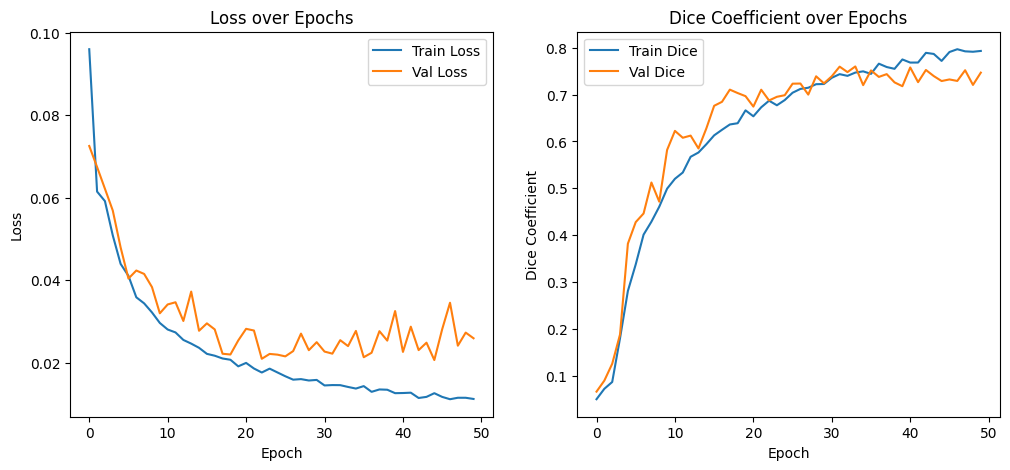

In [8]:

# Plot training and validation loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation dice coefficient
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


model = load_model('final_brain_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[dice_coef])


history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[dice_stop]
)


Epoch 1/10
153/153 [==============================] - 1285s 8s/step - loss: 0.0095 - dice_coef: 0.8251 - val_loss: 0.0264 - val_dice_coef: 0.7730
Epoch 2/10
153/153 [==============================] - 1239s 8s/step - loss: 0.0089 - dice_coef: 0.8336 - val_loss: 0.0238 - val_dice_coef: 0.7745
Epoch 3/10
153/153 [==============================] - 1281s 8s/step - loss: 0.0087 - dice_coef: 0.8382 - val_loss: 0.0276 - val_dice_coef: 0.7679
Epoch 4/10
153/153 [==============================] - 1668s 11s/step - loss: 0.0083 - dice_coef: 0.8452 - val_loss: 0.0267 - val_dice_coef: 0.7762
Epoch 5/10
153/153 [==============================] - 1749s 11s/step - loss: 0.0080 - dice_coef: 0.8507 - val_loss: 0.0289 - val_dice_coef: 0.7721
Epoch 6/10
153/153 [==============================] - 1561s 10s/step - loss: 0.0080 - dice_coef: 0.8496 - val_loss: 0.0278 - val_dice_coef: 0.7733
Epoch 7/10
153/153 [==============================] - 1068s 7s/step - loss: 0.0079 - dice_coef: 0.8512 - val_loss: 0.0277

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## **Saving Model**

In [12]:
model.save('final_brain_segmentation_model_v2.h5')

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
model.save('final_brain_segmentation_model.h5')

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Load an Image for Prediction and Compare with the Original Mask**

1/1 [==============================] - 0s 172ms/step
Dice Coefficient: 0.9278


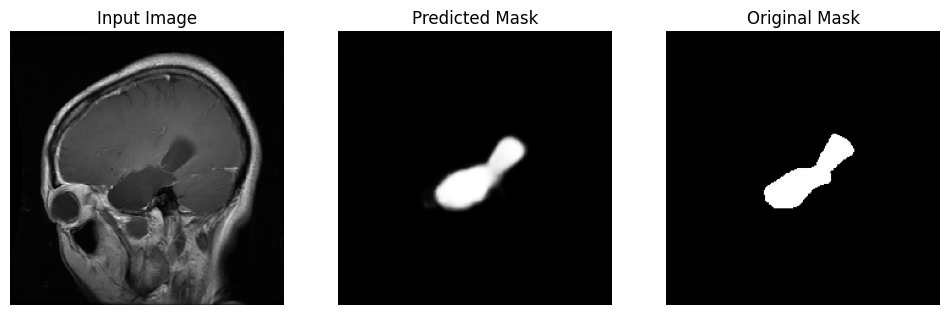

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path, target_size=(224, 224)):
    """Load an image and preprocess it for model prediction."""
    img = load_img(image_path, target_size=target_size)  # Load image
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    return img

def load_mask(mask_path, target_size=(224, 224)):
    """Load a mask image and preprocess it."""
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")  # Load grayscale mask
    mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
    return mask

# ====================================================
# Load an Image for Prediction and Compare with Original Mask
# ====================================================
# Paths to the test image and its corresponding mask
pred_img_path = "Data/images/3017.png"   # Replace with your actual path
pred_mask_path = "Data/masks/3017.png"    # Replace with your actual path

# Load and preprocess the image & mask
test_image = load_image(pred_img_path)  # Shape: [224, 224, 3]
test_mask = load_mask(pred_mask_path)   # Shape: [224, 224, 1]

# Expand dimensions to add batch size for prediction
test_image_expanded = np.expand_dims(test_image, axis=0)  # Shape: [1, 224, 224, 3]

# Predict the mask using the trained model
predicted_mask = model.predict(test_image_expanded)[0]  # Remove batch dimension

# Convert predicted mask to binary (Threshold at 0.5)
predicted_mask_binary = (predicted_mask > 0.5).astype(np.float32)

# ====================================================
# Compute Dice Coefficient
# ====================================================
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Compute the Dice coefficient between two masks."""
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Ensure float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Ensure float32
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Compute Dice Score
dice_score = dice_coefficient(test_mask, predicted_mask_binary).numpy()
print(f"Dice Coefficient: {dice_score:.4f}")

# ====================================================
# Visualize Input Image, Predicted Mask, and Original Mask
# ====================================================
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.show()
